Create dataset with GDM only pregnancies

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [2]:
df= pd.read_csv('BibFullDataset.csv')
df=df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12950 entries, 0 to 12976
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ethnicity             10706 non-null  object 
 1   maternalDiabetes      12396 non-null  object 
 2   fhEclampsia           10594 non-null  object 
 3   gdm                   10592 non-null  object 
 4   gdmDiet               12950 non-null  object 
 5   gdmInsulin            12950 non-null  object 
 6   gdmLifestyle          12950 non-null  object 
 7   gdmMetformin          12950 non-null  object 
 8   gdmNoTreatment        12950 non-null  object 
 9   gdmNotDoc             12950 non-null  object 
 10  gestHypertension      10582 non-null  object 
 11  gestEclampsia         10582 non-null  object 
 12  fhDiabetes            10594 non-null  object 
 13  pregdm                4653 non-null   object 
 14  premacrosomia         5740 non-null   object 
 15  maternalAge        

# Keep GDM pregnancies only

In [11]:
# see how many women have GDM
(df['gdm'].value_counts(normalize=True, dropna=False)*100).apply(lambda x: float("{:.1f}".format(x)))

No     75.2
NaN    18.2
Yes     6.5
Name: gdm, dtype: float64

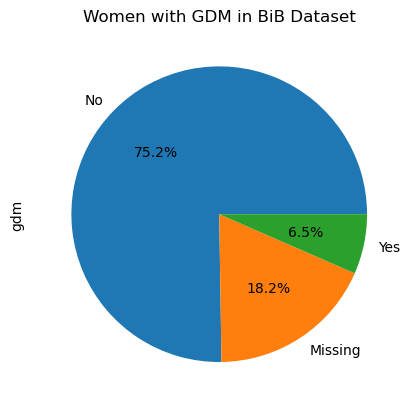

In [14]:
#df.groupby('gdm').size().plot(kind='pie', autopct='%.2f')
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('Women with GDM in BiB Dataset')
mylabels = ["No", "Missing", "Yes"]
(df['gdm'].value_counts(normalize=True, dropna=False)*100).plot(kind='pie', autopct='%1.1f%%', labels = mylabels)
fig.savefig('figures/bib_GDM_piechart.svg', format='svg', dpi=1200)

In [5]:
# create new dataset with GDM women only
df_gdm = df[df['gdm'] == 'Yes']

In [6]:
df_gdm.shape

(848, 34)

In [7]:
df_gdm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848 entries, 7 to 12891
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ethnicity             811 non-null    object 
 1   maternalDiabetes      786 non-null    object 
 2   fhEclampsia           846 non-null    object 
 3   gdm                   848 non-null    object 
 4   gdmDiet               848 non-null    object 
 5   gdmInsulin            848 non-null    object 
 6   gdmLifestyle          848 non-null    object 
 7   gdmMetformin          848 non-null    object 
 8   gdmNoTreatment        848 non-null    object 
 9   gdmNotDoc             848 non-null    object 
 10  gestHypertension      847 non-null    object 
 11  gestEclampsia         847 non-null    object 
 12  fhDiabetes            848 non-null    object 
 13  pregdm                479 non-null    object 
 14  premacrosomia         519 non-null    object 
 15  maternalAge          

In [8]:
# find percentage of LGA infants in GDM dataset
df_gdm['lga'].value_counts(normalize=True, dropna=False)*100

No     89.740566
Yes    10.259434
Name: lga, dtype: float64

In [9]:
df_gdm['lga'].value_counts()


No     761
Yes     87
Name: lga, dtype: int64

In [10]:
# save BiB-GDM datatset
df_gdm.to_csv('BibGDMFullDataset.csv', index=False)

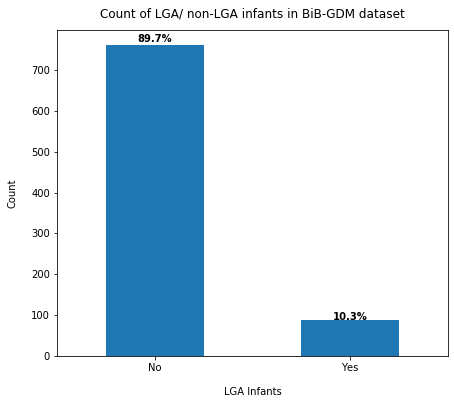

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

total_infants = df_gdm['lga'].size


# compute percentage of LGA/ non-LGA infants
df1=pd.DataFrame()
df1['Percentage'] = df_gdm['lga'].value_counts(normalize=True, dropna=False)*100
df1['Percentage'][1]


# plot bar chart of LGA/ non-LGA infants
ax = df_gdm['lga'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("LGA Infants", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Count of LGA/ non-LGA infants in BiB-GDM dataset", y=1.02);


# print percentage of LGA/ non-LGA infants over each bar
i = 0
for p in ax.patches:

    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str("{:.1f}".format(df1.Percentage[i]))+'%',
             ha='center',
             weight='bold')
    i+=1
fig.savefig('figures/bib_GDM_LGA_nonLGA_barchart.svg', format='svg', dpi=1200)
plt.show()

# Make feature and target dataframes

In [8]:
# make feature matrix and target matrix
X = df_gdm.drop(columns=['lga'])
y = df_gdm['lga']

X.to_csv('BibGDMFeaturesMatrix.csv', index=False)
y.to_csv("BibGDMDependentVariableLGA.csv", index=False)


In [9]:
# encode target variable 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
#print(y)

In [10]:
# define categorical and numeric transformers
numeric_transformer = Pipeline(steps=[
    ('knnImputer', KNNImputer(n_neighbors=2, weights="uniform")),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#  dispatch object columns to the categorical_transformer and remaining columns to numerical_transformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, selector(dtype_include=['object'])),
    ('num', numeric_transformer, selector(dtype_include=['float64','int64']))
])

X = pd.DataFrame(preprocessor.fit_transform(X))

# Rename Feature columns after Preprocessing and OHE

In [11]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        print('\n\ntransformer: ', transformer_in_columns[0])
        
        raw_col_name = list(transformer_in_columns[2])
        
        if isinstance(transformer_in_columns[1], Pipeline): 
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
            
        try:
          if isinstance(transformer, OneHotEncoder):
            names = list(transformer.get_feature_names_out(raw_col_name))
            
          elif isinstance(transformer, SimpleImputer) and transformer.add_indicator:
            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [raw_col_name[idx] + '_missing_flag' for idx in missing_indicator_indices]

            names = raw_col_name + missing_indicators
            
          else:
            names = list(transformer.get_feature_names_out())
          
        except AttributeError as error:
          names = raw_col_name
        
        print(names)    
        
        col_name.extend(names)
            
    return col_name

In [12]:
newColNames=get_column_names_from_ColumnTransformer(preprocessor)



transformer:  cat
['ethnicity_Other', 'ethnicity_South Asian', 'ethnicity_White', 'ethnicity_missing', 'maternalDiabetes_No', 'maternalDiabetes_Yes', 'maternalDiabetes_missing', 'fhEclampsia_No', 'fhEclampsia_Not documented', 'fhEclampsia_Yes', 'fhEclampsia_missing', 'gdm_Yes', 'gdmDiet_No', 'gdmDiet_Yes', 'gdmInsulin_No', 'gdmInsulin_Yes', 'gdmLifestyle_No', 'gdmLifestyle_Yes', 'gdmMetformin_No', 'gdmMetformin_Yes', 'gdmNoTreatment_No', 'gdmNoTreatment_Yes', 'gdmNotDoc_No', 'gdmNotDoc_Not documented', 'gestHypertension_No', 'gestHypertension_Yes', 'gestHypertension_missing', 'gestEclampsia_No', 'gestEclampsia_Yes', 'gestEclampsia_missing', 'fhDiabetes_No', 'fhDiabetes_Not documented', 'fhDiabetes_Yes', 'pregdm_No', 'pregdm_Yes', 'pregdm_missing', 'premacrosomia_No', 'premacrosomia_Yes', 'premacrosomia_missing']


In [13]:
newColNames

['ethnicity_Other',
 'ethnicity_South Asian',
 'ethnicity_White',
 'ethnicity_missing',
 'maternalDiabetes_No',
 'maternalDiabetes_Yes',
 'maternalDiabetes_missing',
 'fhEclampsia_No',
 'fhEclampsia_Not documented',
 'fhEclampsia_Yes',
 'fhEclampsia_missing',
 'gdm_Yes',
 'gdmDiet_No',
 'gdmDiet_Yes',
 'gdmInsulin_No',
 'gdmInsulin_Yes',
 'gdmLifestyle_No',
 'gdmLifestyle_Yes',
 'gdmMetformin_No',
 'gdmMetformin_Yes',
 'gdmNoTreatment_No',
 'gdmNoTreatment_Yes',
 'gdmNotDoc_No',
 'gdmNotDoc_Not documented',
 'gestHypertension_No',
 'gestHypertension_Yes',
 'gestHypertension_missing',
 'gestEclampsia_No',
 'gestEclampsia_Yes',
 'gestEclampsia_missing',
 'fhDiabetes_No',
 'fhDiabetes_Not documented',
 'fhDiabetes_Yes',
 'pregdm_No',
 'pregdm_Yes',
 'pregdm_missing',
 'premacrosomia_No',
 'premacrosomia_Yes',
 'premacrosomia_missing']

In [14]:
newColNames.extend(('maternalAge','parity', 'bookingWeight', 'bookingBMI','thirdTrimesterWeight','maternalHeight',
                    'fastingGlucose', 'postGlucose',
                    'meanAbdomCirc', 'maxAbdomCirc', 'minAbdomCirc','varAbdomCirc', 'rangeAbdomCirc',
                    'meanFoetalWeight', 'maxFoetalWeight', 'minFoetalWeight','varFoetalWeight', 'rangeFoetalWeight'))

In [15]:
X.columns = newColNames
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ethnicity_Other             848 non-null    float64
 1   ethnicity_South Asian       848 non-null    float64
 2   ethnicity_White             848 non-null    float64
 3   ethnicity_missing           848 non-null    float64
 4   maternalDiabetes_No         848 non-null    float64
 5   maternalDiabetes_Yes        848 non-null    float64
 6   maternalDiabetes_missing    848 non-null    float64
 7   fhEclampsia_No              848 non-null    float64
 8   fhEclampsia_Not documented  848 non-null    float64
 9   fhEclampsia_Yes             848 non-null    float64
 10  fhEclampsia_missing         848 non-null    float64
 11  gdm_Yes                     848 non-null    float64
 12  gdmDiet_No                  848 non-null    float64
 13  gdmDiet_Yes                 848 non

In [16]:
X.to_csv('BibGDMFeaturesMatrix_Preprocessed_OHEColumnsNamed.csv', index=False)
y = pd.DataFrame(y)
y.to_csv("BibGDMDependentVariableLGAEncoded.csv", index=False)